# Problem 1

### Getting familiar with loading, visualizing and operating on multivariate data

A Hess diagram is a 2D plot coded by a third quantity.

Here's an example from the [astroML documentation](https://www.astroml.org/examples/datasets/plot_SDSS_SSPP.html) showing the temperature and surface gravity (how strongly the star would pull on you if you could stand on it's surface, including the effect of rotation), color coded on the left by density, and on the right by metallicity (measured here as the ratio of iron to hydrogen) with density contours.


<img src="https://www.astroml.org/_images/plot_SDSS_SSPP_1.png">

From http://das.sdss.org/va/stripe_82_variability/SDSS_82_public/, download eight HLC\*fits.gz files (and recall how you can use `astropy.io.fits` to load these)

The HLC files are each different bands on the sky.

For each HLC file, separate stars and galaxies by using the `MEAN_OBJECT_TYPE` column and making a cut with value > 5 to find stars.

For each HLC file, and separately for stars and galaxies make a 3-panel plot.

In the left plot show `r` vs `g-i` color coded by density (recall we did this with `seaborn`'s `jointplot`, but you can use whatever).

Estimate a bivariate distribution for `density(r, g-i)` this sample (recall we did with `seaborn`'s `jointplot` use `kde`, but you can use whatever).

In the middle and right panel, again plot `r` vs `g-i`, but now color-coded by proper motion in RA, and Dec. Overlay the density contors.

Comment on the structure in stars vs galaxies, and the evolution with position on the sky in each HLC.


In [1]:
import astropy.table as at
import astropy.io.fits as afits
import glob
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import matplotlib.animation as animation
import imageio
from scipy.stats import binned_statistic_2d, iqr
import os


warnings.filterwarnings('ignore') # suppress annoying deprecation warnings
sns.set(style='white', font_scale=1.2)

In [2]:
# read in files and split into separate dataframes for stars + galaxies
def read_file(fits_file):
    
    # FITS is a format that is pretty similar to HDF5 but has a different byte order
    # Big Endian vs Little Endian
    # It's unfortunately very common is astrophysics and a few other disciplines 
    # Consequently, it makes sense to see how to open it
    fits = afits.open(fits_file)
    data = fits[1].data
    
    # pull only the columns we need
    g = data['MEAN_PSFMAG'][:,1]
    r = data['MEAN_PSFMAG'][:,2]
    i = data['MEAN_PSFMAG'][:,3]
    ra_pm    = data['RA_PM']
    dec_pm   = data['DEC_PM']
    obj_type = data['MEAN_OBJECT_TYPE']
    
    # trim bad data - part of this exercise was making sure you can do this
    # you can do the same thing with pandas with a similar syntax
    ind = (g > 0) & (r > 0) & (i > 0)
    g = g[ind]
    r = r[ind]
    i = i[ind]
    ra_pm = ra_pm[ind]
    dec_pm = dec_pm[ind]
    obj_type = obj_type[ind] 
    g_i = g-i
    
    # trim to the core of the data - you can plot without this but the bulk of the stars are here
    # This is testing that you filter irrelevant details from your dataset to see structure
    col_mag_cut = ((g_i > -1.5) & (g_i < 4.5) &\
                   (r > 11) & (r < 23))
    
    g_i = g_i[col_mag_cut]
    r   = r[col_mag_cut]
    ra_pm    = ra_pm[col_mag_cut]
    dec_pm   = dec_pm[col_mag_cut]
    obj_type = obj_type[col_mag_cut]
    
    # make a data frame/astropy table
    df = at.Table({'g_i':g_i, 'r':r, 'ra_pm':ra_pm, 'dec_pm':dec_pm, 'obj_type':obj_type})
    
    # split stars and galaxies
    df_stars = df[df['obj_type'] > 5]
    df_galaxies = df[df['obj_type'] <= 5]
    return df_stars, df_galaxies

In [3]:
def forceAspect(ax,aspect):
    """
    Some code I got from stack overflow to make imshow axes some aspect ratio
    """
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)

    

def plot_data(df, ax1, ax2, ax3, title):
    '''
    We're always making a 3 plot image so write a function to do this for 
    a data frame/table without worrying about if we're plotting stars or galaxies
    We'll make the image limits the same and binning same, and colorbars same 
    We'll also save each figure individually
    '''
    
    
    # keep limits and bins the same
    # you can fiddle with binsizes, but these are generally reasonable for magnitudes and colors
    lims=np.array([[-1.5,4.5],[11,23]])
    xbins = np.arange(-1.5, 4.55, 0.05)
    ybins = np.arange(11, 23.1, 0.1)
    
    # convert the data to a 2D histogram
    h1, xedges, yedges = np.histogram2d(df['g_i'], df['r'],
                                        bins=[xbins, ybins], range=lims)
    
    # there are many ways to color by a third quantity
    # this is one, but a few of you have taken other approaches
    # scan the homework directory to see how others approached this
    ra_pm = binned_statistic_2d(df['g_i'], df['r'], df['ra_pm'],
                                statistic='median', bins=[xbins, ybins], range=lims)[0]
    dec_pm = binned_statistic_2d(df['g_i'], df['r'], df['dec_pm'],
                                 statistic='median', bins=[xbins, ybins], range=lims)[0]
    
    
    # probably could have fixed RA_PM in the I/O function
    # we didn't so we shouldn't count bins with the binned RA_PM is infinite
    # it's enough to do this with either RA or Dec PM
    h1[~np.isfinite(ra_pm)] = np.nan
    
    # demand all the axes have the same x and y limits
    ax1.set_xlim(lims[0])
    ax1.set_ylim(lims[1])
    ax2.set_xlim(lims[0])
    ax2.set_ylim(lims[1])
    ax3.set_xlim(lims[0])
    ax3.set_ylim(lims[1])
    
    # magnitudes are backward
    ax1.invert_yaxis()
    ax2.invert_yaxis() 
    ax3.invert_yaxis() 
    
    # show histograms - I got the limits by running this code once to set the limits
    im1 = ax1.imshow(h1.T[::-1], interpolation='None',
               cmap=plt.cm.plasma,  extent=lims.ravel(), vmin=1, vmax=1042/2)
    # print(np.nanmax(h1.ravel()), np.nanmin(h1.ravel()) )
    
    # note that shared axis limits is not the same as shared axis ratio!
    # you'll have to do this for each one
    forceAspect(ax1, 1.)
    
    im2 = ax2.imshow(ra_pm.T[::-1], extent=lims.ravel(), interpolation='None',
               cmap=plt.cm.Spectral, vmin=-0.02, vmax=0.02)
    forceAspect(ax2, 1.)
    
    im3 = ax3.imshow(dec_pm.T[::-1], extent=lims.ravel(), interpolation='None',
                    cmap=plt.cm.Spectral, vmin=-0.02, vmax=0.02)
    forceAspect(ax3, 1.)
    
    # add a colobar - we'll resize the axes later and this will break height
    # we could return im, and create this later to fix that but meh
    pos = ax3.get_position()
    cax = fig.add_axes([pos.x1+0.01,pos.y0,0.015,pos.height])
    cbar = fig.colorbar(im3, cax=cax, label='Proper motion')
    
    # add contours on the proper motion plots
    # we're using the same downsampling trick we did in class to compute contours faster
    samp = df[::10]
    sns.kdeplot(samp['g_i'], samp['r'], ax=ax2, legend=False)
    sns.kdeplot(samp['g_i'], samp['r'], ax=ax3, legend=False)
    
    # disable tick labels
    ax2.axes.get_yaxis().set_ticks([])
    ax3.axes.get_yaxis().set_ticks([])

    # add labels - only on the lower row
    if title == 'galaxies':
        for ax in (ax1, ax2, ax3):
            ax.set_xlabel('g-i')
    ax1.set_ylabel(f'r {title}')
    
    return 

In [4]:
# this will give you a list sorted by filename
files = sorted(glob.glob('HLC*.fits.gz'))
fits_files = files[4:] + files[0:4] # this just sorts the files by RA range instead of filename


# supress plots from showing up for each FITS image
plt.ioff()

for i, fits_file in enumerate(fits_files):
    
    # no reason to rerun the slow figure generating code over and over
    # once we make figures we're happy with, save them and then you can just alter the code that makes
    # the gif instead - delete the files, or comment out to recreate
    if os.path.exists(f'{i}.png'):
        continue
        
    ra_lim = fits_file.split('_')[1], fits_file.split('_')[3].split('.')[0]
    df_stars, df_galaxies = read_file(fits_file)
    
    # set up figure
    # note that I need 3 axis per set of stars and galaxies
    # but I'm putting them all in a single figure instance
    # note you can use sharex, sharey as well 
    fig, (row1, row2) = plt.subplots(2,3, figsize=(12,8))
    
    fig.suptitle('{} < RA < {}'.format(*ra_lim))
    
    ax1 = row1[0]
    ax2 = row1[1]
    ax3 = row1[2]
    plot_data(df_stars, ax1, ax2, ax3, 'stars')
    
    ax4 = row2[0]
    ax5 = row2[1]
    ax6 = row2[2]
    plot_data(df_galaxies, ax4, ax5, ax6, 'galaxies')
    
    plt.subplots_adjust(left=0.065, right=0.85, bottom=0.115, top=0.9, wspace=0., hspace=0.)
    fig.savefig(f'{i}.png')
    plt.close(fig) # good practice - you'll find you hit practical limits quite quickly in this class

    
gif_path = "combined.gif"
frames_path = "{i}.png"
n = len(fits_files)

if not os.path.exists(gif_path):
    with imageio.get_writer(gif_path, mode='I', fps=0.85) as writer:
        for i in range(n):
            writer.append_data(imageio.imread(frames_path.format(i=i)))

![Combined Hess Diagram](combined.gif)


### Note how the density of stars changes across the sky. I'm keeping all the limits on all axes the same to help comparison. Look at where you are looking in each range. This is particularly evident along the y-axis as you lose a lot of stars that are at lower magnitudes as we step through RA - i.e. brighter stars. Look at a map of the sky, and look at where the Milky Way is to understand why. It's also happening in color - as you move through RA, you are looking at a different amount of dust that is largely near the plane of our Galaxy. 

![Sky Map](galaxy.png)

### Note I didn't ask you to make an animation, but it's the most reasonable thing to do when you have multiple plots that are basically the same and want to see some characteristic evolving between them.

### The structure in proper motion is more subtle and if you only plotted a few points you might miss the color gradients in the stars.

### The galaxies are largely fixed against the background and their apparent motion across the sky is invisible for all but the nearest sources. The stars have more structure, because they are not all at a single distance from us. Some are in near spirals arms and streams of the Milky Way. Others are more distant. That red edge in DEC_PM (which is blue-ish green in RA_PM) is something we'll revisit.

### Also, remember this is not a programming class - it's fine to be unfamiliar with python and refer back to these solutions for how to do something, even on exams.  You don't have to learn the minutiae of matplotlib. You do have to think about how to visualize your data effectively.

# Problem 2

### Comparing distributions to a standard normal distribution

Load the `IntroStat_demo.csv` file in the data directory (use `pandas` or `astropy` or whatever you like).

Estimate the sample mean and variance of the suspiciously named `mag.outlier` column.

Make a Q-Q plot of the `mag.outlier` column and over plot a line with `Y = Mean + Sigma*X` on it. 

Calculate the values of the first and third quartiles, and use some linear algebra to figure out the equation of a line passing through them (google line 2 point form if you need a refresher on the linear algebra)

Overplot that line passing through the data.

Now try the same thing with `mag.het`. Describe what you found?

What happens if you rescale the data? Subtract of the sample mean of `mag.het` and divide by `mag.het.error`. Now repeat the Q-Q plot with this quantity. 

Describe what's going on.

In [5]:
plt.ion()
%matplotlib inline

# if you are on a Mac, this is nice
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import statsmodels.api as sm
import scipy.stats as st
from astropy.visualization import hist as ahist

In [6]:
# read the data
df = pd.read_csv("../../data/01/IntroStat_demo.csv")

In [7]:
# define a function to do the analysis
def qq_analysis(data, title=None):

    fig = plt.figure(figsize=(11, 5))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    samp_mean = data.mean()
    samp_std  = data.std()
    label = f'Sample Mean {samp_mean:.3f},\nSample Stddev {samp_std:.3f}'

    # histogram the data
    ahist(data, ax=ax1, bins='freedman',  normed=True)
    data_range = ax1.get_xlim()

    # overlay a Gaussian with the moments we just estimated
    data_vals = np.arange(*data_range, 0.01)
    p = st.norm.pdf(data_vals, loc=samp_mean, scale=samp_std)
    ax1.plot(data_vals, p, color='C1', label=label)
    if  title is not None:
        ax1.set_xlabel(title)
    ax1.legend(frameon=False)

    # qq plot
    sm.qqplot(data, marker='.', color='C0', ax=ax2)

    def mom_line(x):
        return samp_mean + samp_std*x

    # overlay the line with the moments
    xvals = np.arange(-3, 3, 0.1)
    ax2.plot(xvals, mom_line(xvals), color='C1', label='Method of Moments Line')

    qq_25_75 = np.percentile(data, [25, 75])
    x_25 = st.norm.ppf(0.25)
    x_75 = st.norm.ppf(0.75)

    def iqr_line(xvals):
        return ((xvals - x_25)/(x_75-x_25)) * (qq_25_75[1] - qq_25_75[0] ) + qq_25_75[0]
    
    ax2.plot(xvals, iqr_line(xvals), color='C2', label='IQR line')
    ax2.legend(frameon=False)
    
    plt.subplots_adjust(left=0.1, right=0.8, hspace=0.1, bottom=0.1, top=0.99)
    fig.tight_layout()
    return 

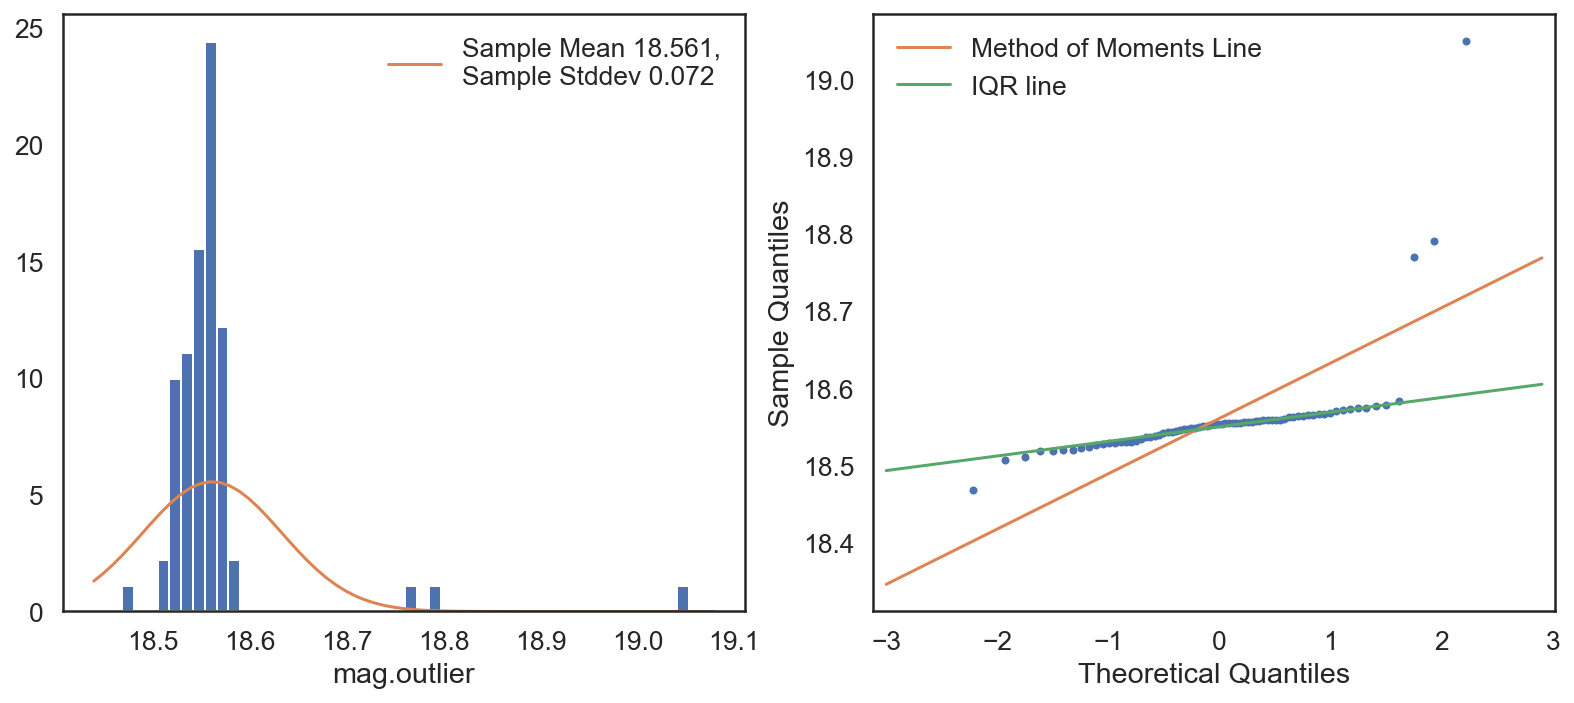

In [8]:
qq_analysis(df['mag.outlier'], title='mag.outlier')

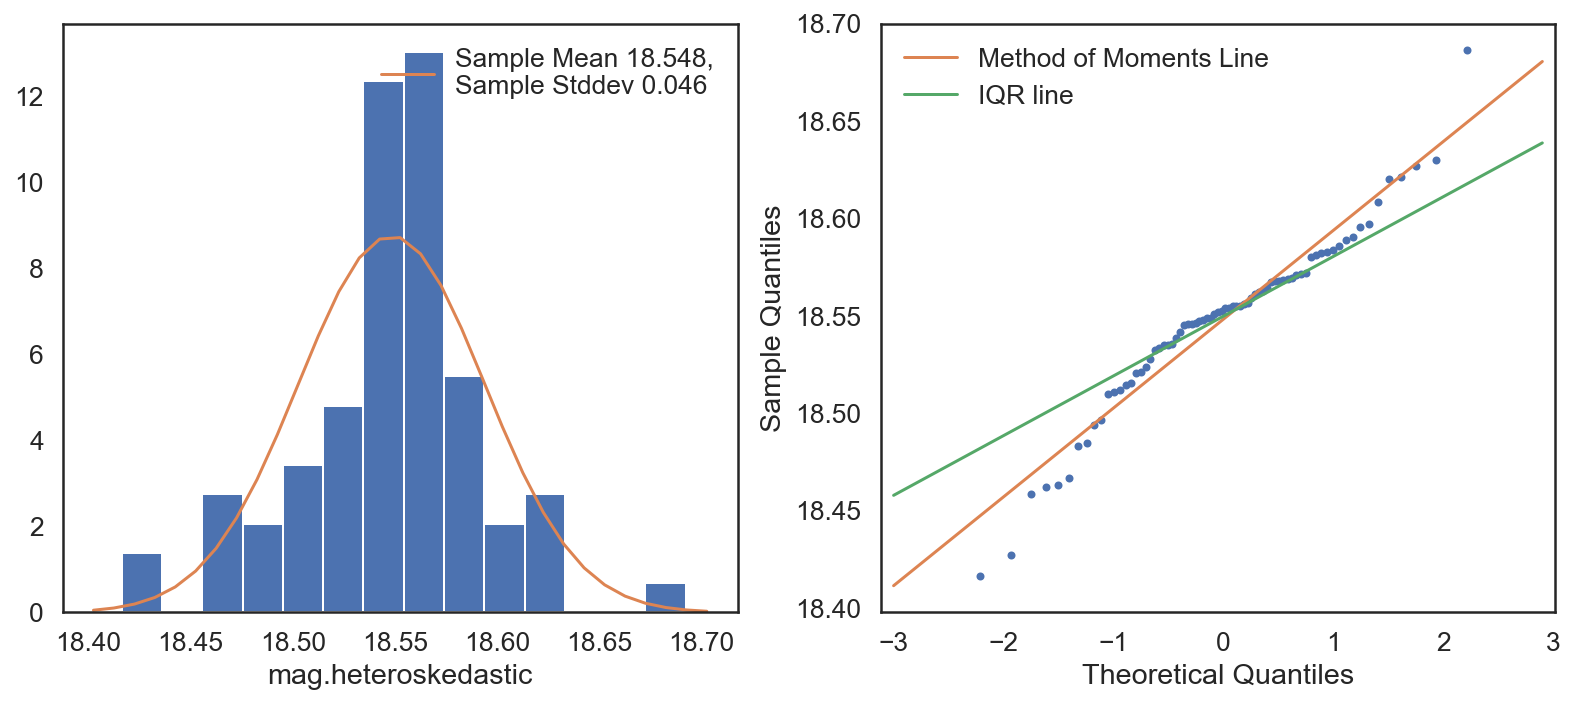

In [9]:
qq_analysis(df['mag.het'], title='mag.heteroskedastic')

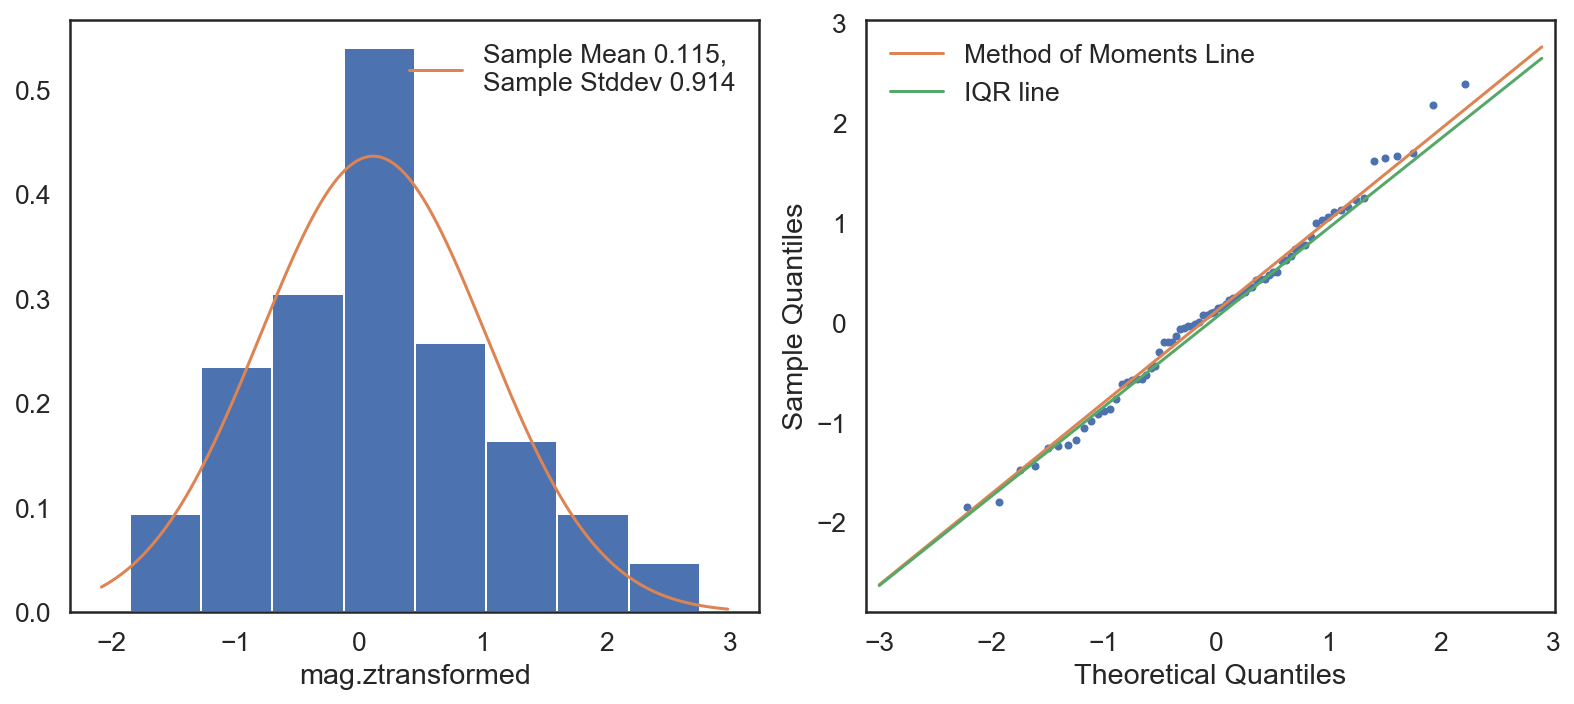

In [10]:
df['z'] = (df['mag.het'] - df['mag.het'].mean())/df['mag.het.error']
qq_analysis(df['z'], title='mag.ztransformed')

### Here, as in most cases you'll encounter in the real world, the data have some uncertainty, and the uncertainty is not the same per measurement. Relative to the IQR line, measurements at lower-quartiles have smaller errors and measurements at higher quartiles have larger errors, relative to what you'd expect for normally distributed data. 

### Scaling the measurements by their reported uncertainties helps normalize the data as the measurements at lower quartiles (lower mags = brighter) have smaller uncertainties than those at higher quartiles (higher mags = fainter). This particular transformation is called the z-transformation. It's not the only one you can do, but it is by far the most common one you'll see. 

# Problem 3

The demo data set for this part is the Wesenheit index of the OGLE-III fundamental-mode and first overtone classical Cepheids. 

These stars are awesome because you can use them to measure distances. Here's a nice [youtube video](https://www.youtube.com/watch?v=iyisAjHdhas) on these stars.

You'll try to estimate their period-luminosity relationship. 

The Wesenheit index is defined as `W = I - 1.55(V - I)`, and its main advantage over using simply the I or V photometry is that it is insensitive to extinction. It is denoted by 'W' among the data columns. 

Other columns are 'name', the identifier of the star; 'RA0' (in decimal hours) and 'Decl0' (in decimal degrees), celestial coordinates; 'Mode', the mode of the Cepheid ('F' indicates fundamental-mode, '1' indicates first overtone star); 'Cloud', indicating which Magellanic Cloud the star belongs to; 'logP1', the base-10 logarithm of the period in days; 'VI', the colour V-I.


Split the data into LMC and SMC, and then again by mode F and 1, and plot the `W` on the y-axis vs `log(P1)` on x.
Fit or estimate straight lines to each of the four samples (you can use `statsmodels` `astropy` `scipy` `numpy`....)
(Yes, we've not covered fitting straight lines. That's OK.)

Compute the residuals of each sample to it's respective line. Do these residuals look like a normal distribution? If not, speculate on why (WATCH THE YOUTUBE VIDEO!)

Plot the residuals color coded by if they are positive or negative vs RA and Dec (just like a Hess diagram in Problem 1).

Finally, plot the residuals against the fitted `W` values, and just to anticipate the next homework assignment, also plot `log(P1) vs V-I`. Comment on what you are seeing.

In [11]:
cep = pd.read_csv("../../data/01/Cepheids.csv")

In [12]:
lmcf = cep[(cep['Cloud'] == 'LMC') & (cep['Mode'] == 'F')]
smcf = cep[(cep['Cloud'] == 'SMC') & (cep['Mode'] == 'F')]

lmco = cep[(cep['Cloud'] == 'LMC') & (cep['Mode'] == '1')]
smco = cep[(cep['Cloud'] == 'SMC') & (cep['Mode'] == '1')]

In [13]:
cols = {'LMC':'C0', 'SMC':'C1'}
markers = {'F':'o', '1':'s'}
sample = [(lmcf, smcf), (lmco, smco)]


def get_col_marker(dfr):
    col = cols.get(dfr['Cloud'].iloc[0], 'k')
    marker = markers.get(dfr['Mode'].iloc[0], '^')
    title = '{:s} {:s}'.format(dfr['Cloud'].iloc[0], dfr['Mode'].iloc[0] )
    return col, marker, title

def plot_samp(s, ax1, ax2, alpha=0.1, ls='-'):
    col, marker, title = get_col_marker(s)
    ax1.scatter(s['logP1'], s['W'], color=col, marker=marker, alpha=alpha, label=title)
    
    m, c, r, p, std = st.linregress(s['logP1'], s['W'])
    label = fr'${m:.3f} \cdot x {c:+.3f}$'

    xvals = ax1.get_xlim()    
    def f(x):
        return m*np.array(x) + c
    
    ax1.plot(xvals, f(xvals), ls=ls, color='k', label=label)
    fitW = f(s['logP1'])
    r = s['W'] - fitW
    sm.qqplot(r, ax=ax2, color=col, marker=marker, alpha=alpha)
    ax2.plot([-3, 3], [-3, 3], color='k', ls=':')
    return r, fitW

    

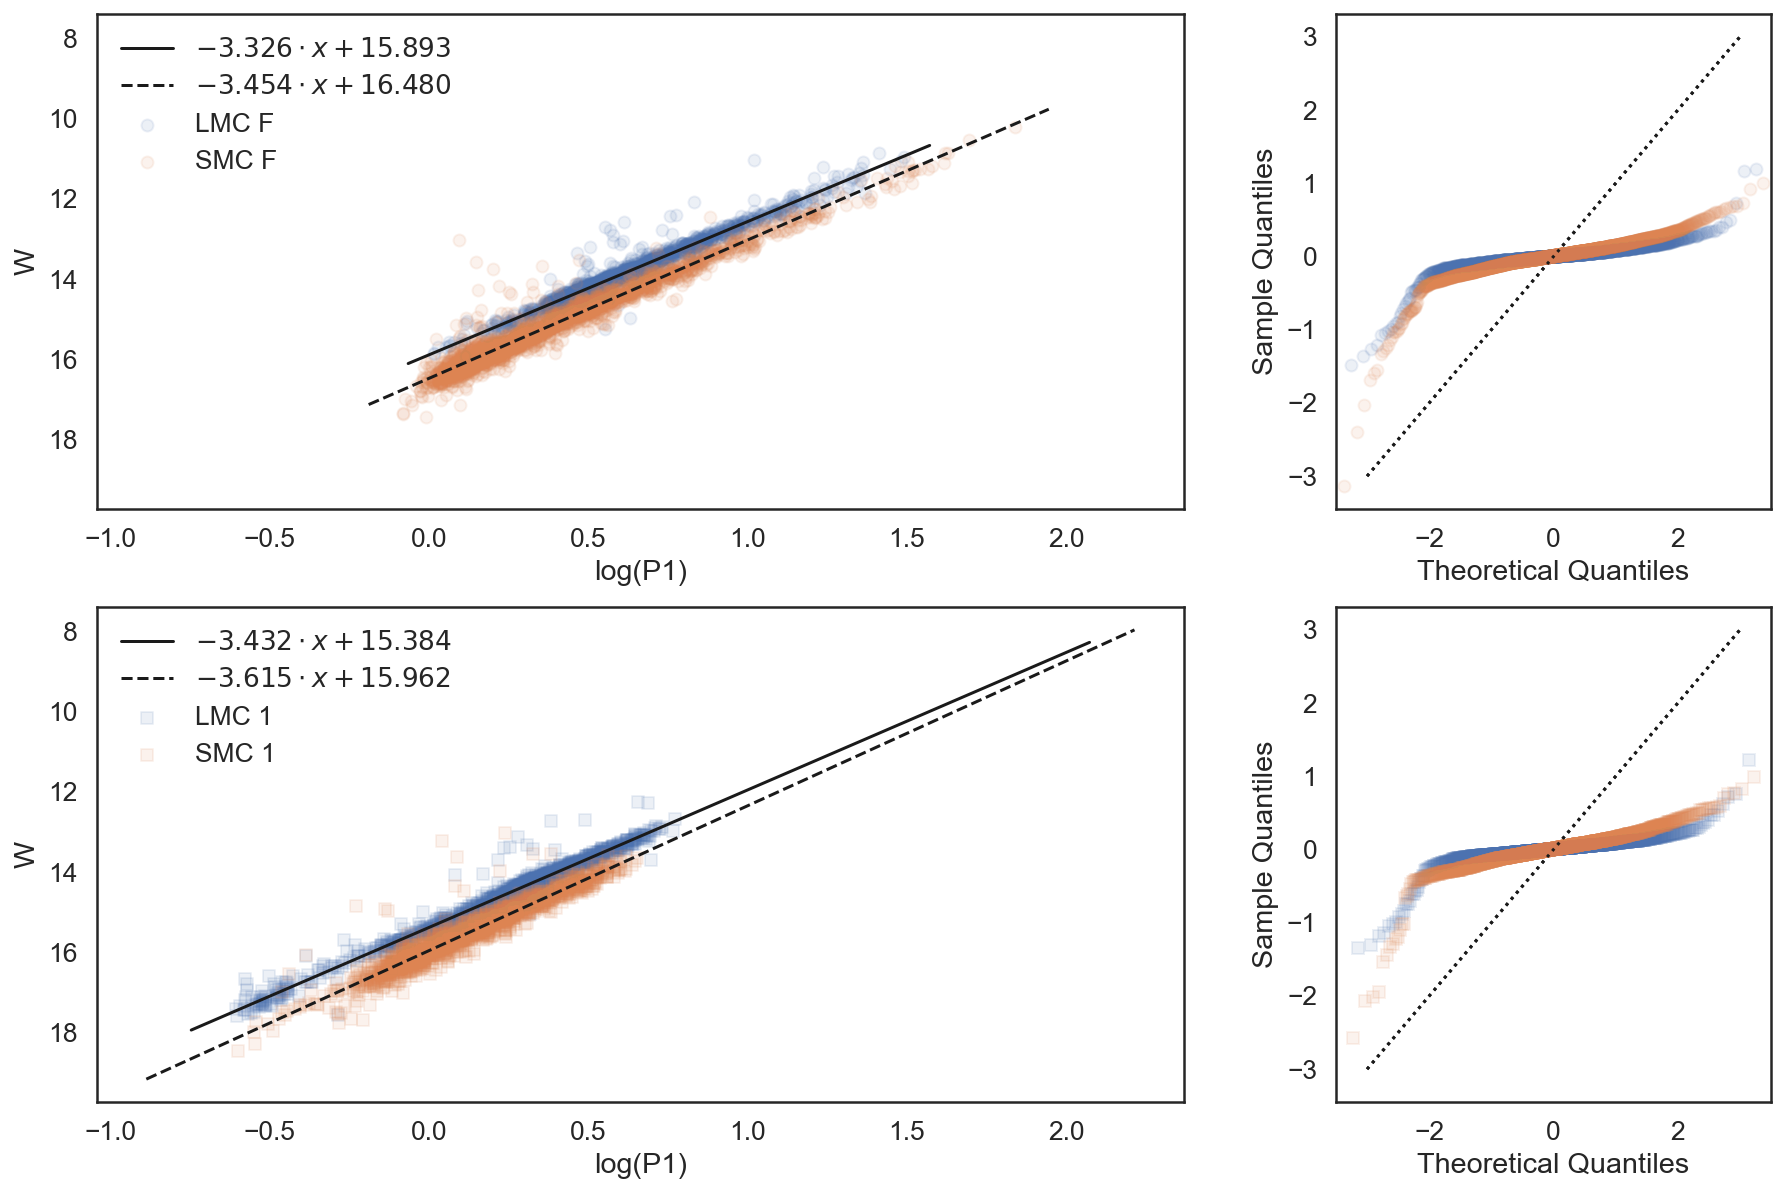

In [14]:
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[2.5,1], height_ratios=[1,1])

shareax1 = None
shareax2 = None
for i, samp in enumerate(sample):
    ax1 = fig.add_subplot(gs[i,0], sharex=shareax1, sharey=shareax1)
    ax2 = fig.add_subplot(gs[i,1], sharex=shareax2, sharey=shareax2)
    if shareax1 is None:
        shareax1 = ax1
        shareax2 = ax2
    
    ls = ['-','--']
    ax1.set_xlabel('log(P1)')
    ax1.set_ylabel('W')
    for j, s in enumerate(samp):
        r, fitW = plot_samp(s, ax1, ax2, ls=ls[j])
        s['resid'] = r
        s['fitW'] = fitW
    ax1.legend(frameon=False)
    
shareax1.invert_yaxis()
    
    
    

In [15]:
sample = [(lmcf, lmco), (smcf, smco)]
def plot_map(s, ax, alpha=0.1):
    _, marker, title = get_col_marker(s)
    col = ['C0' if x <=0 else 'C1' for x in s['resid']]
    ax.scatter(s['RA0'], s['Decl0'], color=col, marker=marker, alpha=alpha)
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    cloud = title.split()[0]
    ax.set_title(cloud)
    



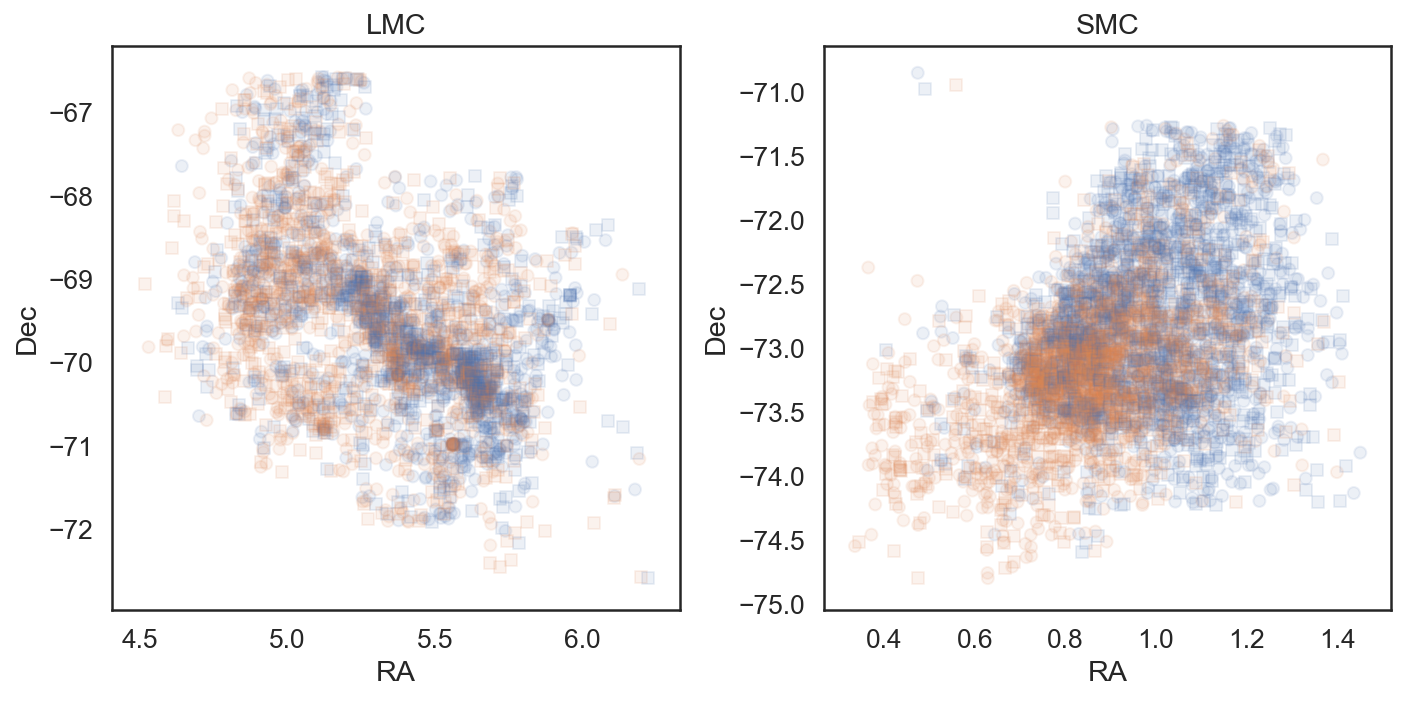

In [16]:
fig = plt.figure(figsize=(10, 5))
gs = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[1,1])
for i, samp in enumerate(sample):
    ax = fig.add_subplot(gs[i])
    for j, s in enumerate(samp):
        plot_map(s, ax)


fig.tight_layout()   

### Hey, that's kinda nifty - apparently the LMC and SMC know something about the sign of our fit residuals...

In [17]:
sample = [(lmcf, smcf), (lmco, smco)]
def plot_resids(s, ax, alpha=0.1):
    col, marker, title = get_col_marker(s)
    ax.scatter(s['fitW'], s['resid'], color=col, marker=marker, alpha=alpha, label=title)
    xvals = np.array(ax.get_xlim())
    ax.plot(xvals, [0,0], ls=':', color='k')
    ax.set_xlabel('fit W')
    ax.set_ylabel('Residual')
    ax.set_ylim(-1.5, 1.5)
    return
 
def plot_corr(s, ax, alpha=0.1, ls='-'):
    col, marker, title = get_col_marker(s)
    ax.scatter(s['VI'], s['logP1'], color=col, marker=marker, alpha=alpha)

    m, c, r, p, std = st.linregress(s['VI'], s['logP1'])
    label = fr'${m:.2f} \cdot x  {c:+.2f}, r={r:.2f}, p={p:.2f}$'
    xvals = ax.get_xlim()    
    def f(x):
        return m*np.array(x) + c
    
    ax.plot(xvals, f(xvals), ls=ls, color='k', label=label)
    ax.set_xlabel('V-I')
    ax.set_ylabel('log(P1)')



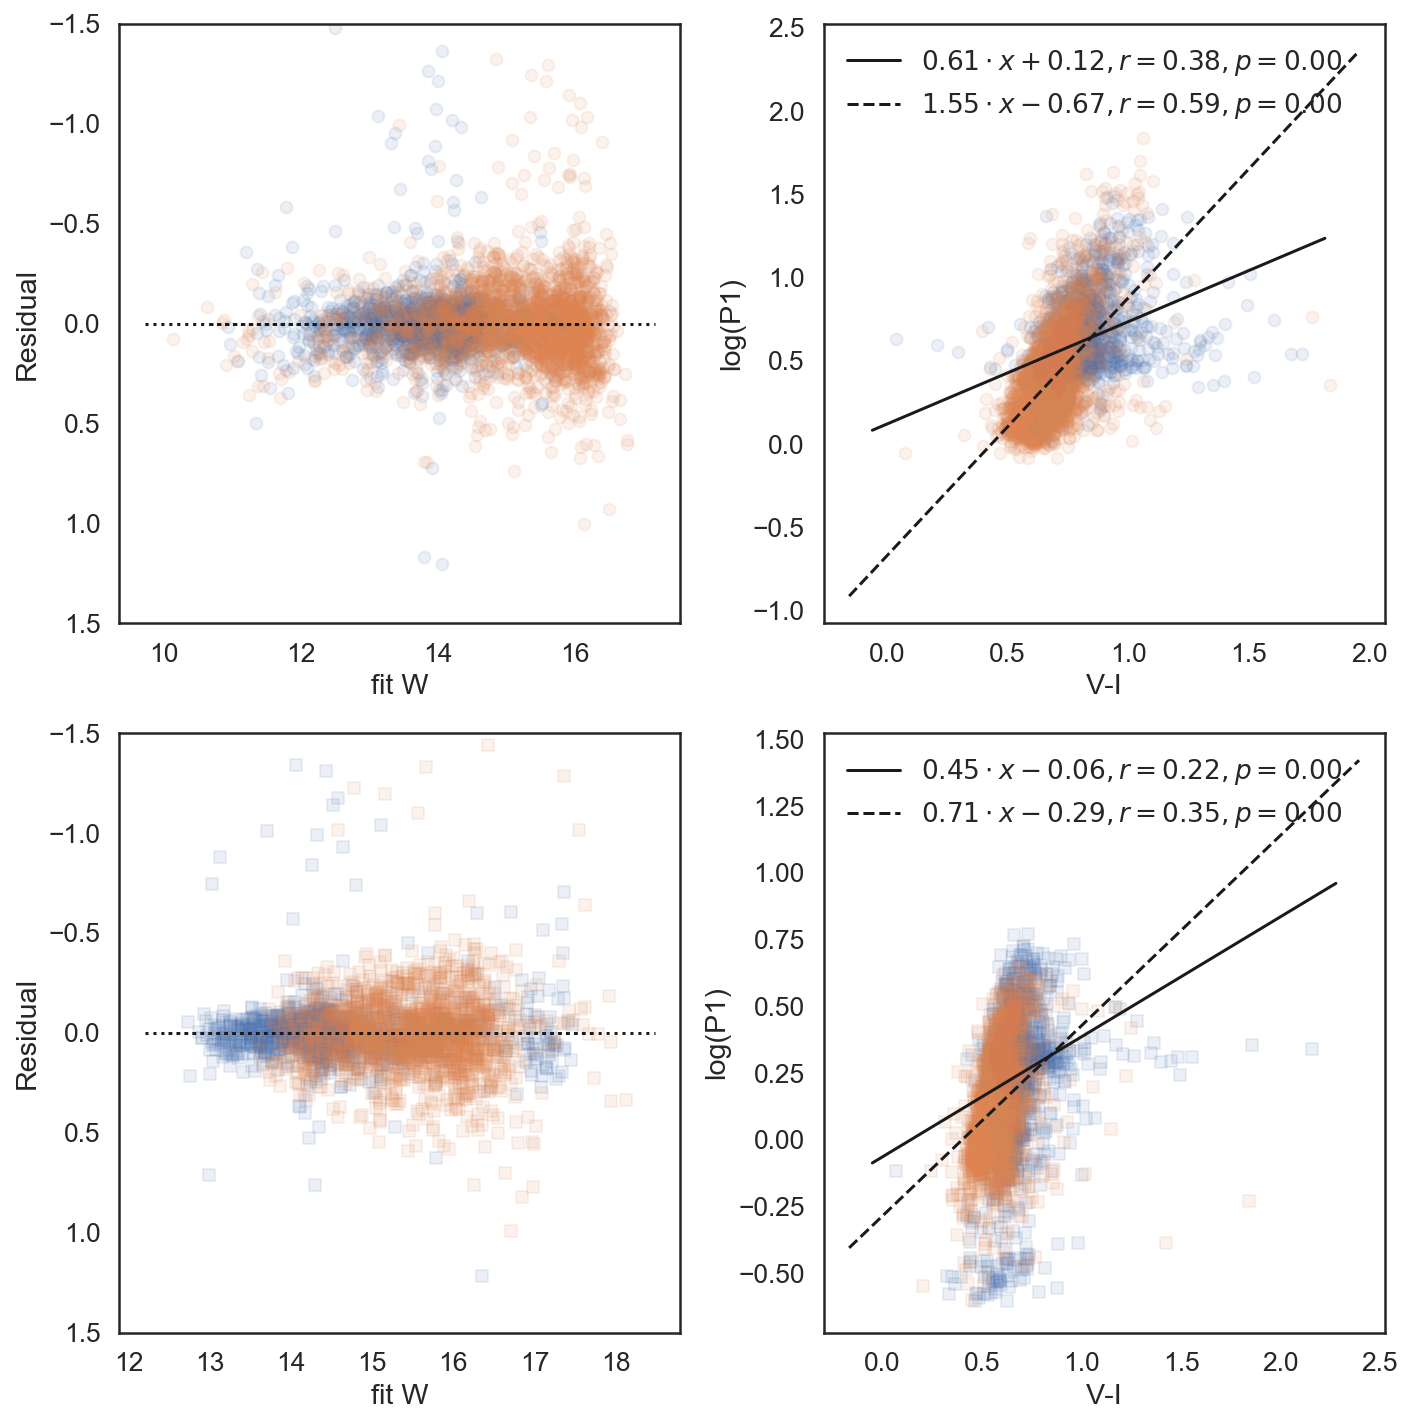

In [18]:
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(ncols=2, nrows=2, height_ratios=[1,1])
for i, samp in enumerate(sample):
    ax1 = fig.add_subplot(gs[i,0])
    ax2 = fig.add_subplot(gs[i,1])
    ls = ['-','--']
    for j, s in enumerate(samp):
        plot_resids(s, ax1)
        plot_corr(s, ax2, ls=ls[j])
    ax2.legend(frameon=False)
    ax1.invert_yaxis()
fig.tight_layout()

### Not only are the residuals not normally distributed, they're assymetric - there's a bunch more objects that where the data is more negative that the fit (i.e. brighter) than there are positive (fainter). This is a selection bias. 

### You wouldn't want to trust the regression coefficients for any relation between V-I and period without accounting for the selection bias - i.e. the population of stars you can't see.

### In fact, we're still not sure if the Cepehids in the LMC and SMC have a true Period-Luminosity-Color relation or if it's largely Period luminosity. We're still studying the Leavitt law.